In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

employees_df = pd.read_csv("employee_dataset2.csv")
jobs_df = pd.read_csv("job_dataset.csv")

employees_df["current_soft_skills"] = employees_df["current_soft_skills"].fillna("")
employees_df["current_tech_stack"] = employees_df["current_tech_stack"].fillna("")
employees_df["soft_tech_combined"] = employees_df["current_soft_skills"] + " " + employees_df["current_tech_stack"]

jobs_df["SOFT_SKILLS_REQUIRED"] = jobs_df["SOFT_SKILLS_REQUIRED"].fillna("")
jobs_df["TECHSTACK_REQUIRED"] = jobs_df["TECHSTACK_REQUIRED"].fillna("")
jobs_df["soft_tech_combined"] = jobs_df["SOFT_SKILLS_REQUIRED"] + " " + jobs_df["TECHSTACK_REQUIRED"]

vectorizer = CountVectorizer()

employee_matrix = vectorizer.fit_transform(employees_df["soft_tech_combined"].astype(str))
job_matrix = vectorizer.transform(jobs_df["soft_tech_combined"].astype(str))

cosine_sim = cosine_similarity(employee_matrix, job_matrix)

def get_top_recommendations(emp_id, num_recommendations=3):
    if emp_id not in employees_df["emp_id"].values:
        print(f"Employee with emp_id {emp_id} not found.")
        return []

    emp_index = employees_df[employees_df["emp_id"] == emp_id].index[0]

    emp_scores = cosine_sim[emp_index]

    job_indices_scores = list(enumerate(emp_scores))

    job_indices_scores.sort(key=lambda x: x[1], reverse=True)

    current_job_index = employees_df[employees_df["emp_id"] == emp_id]["current_job"].index[0]
    job_indices_scores = [(index, score) for index, score in job_indices_scores if index != current_job_index]

    top_recommendations = []
    for index, score in job_indices_scores:
        job = jobs_df.iloc[index]

        current_salary_str = str(employees_df.iloc[emp_index]["salary"]).replace(",", "")
        job_salary_str = str(job["SALARY"]).replace(",", "")

        if current_salary_str and job_salary_str:
            current_salary = float(current_salary_str)
            job_salary = float(job_salary_str)

            salary_gap = abs(job_salary - current_salary)

            if salary_gap <= 0.1 * current_salary and job_salary != current_salary:
                top_recommendations.append((index, score))

            if len(top_recommendations) == num_recommendations:
                break

    return top_recommendations

def recommend_jobs_for_employee(emp_id):

    if emp_id not in employees_df["emp_id"].values:
        print(f"Employee with emp_id {emp_id} not found.")
        return
    employee_details = employees_df[employees_df["emp_id"] == emp_id].iloc[0]

    print(f"Employee Details for {employee_details['employee_name']} (ID: {employee_details['emp_id']}):")
    print(f"- Current Job: {employee_details['current_job']}")
    print(f"- Current Soft Skills: {employee_details['current_soft_skills']}")
    print(f"- Current Tech Stack: {employee_details['current_tech_stack']}")
    print(f"- Years of Experience: {employee_details['years_of_experience']}")
    print(f"- Salary: {employee_details['salary']}")
    print("-" * 50)
    
    top_recommendations = get_top_recommendations(emp_id)
    
    if top_recommendations:
        print(f"Top 3 Job Recommendations for Employee ID {emp_id}:")
        for index, score in top_recommendations:
            job = jobs_df.iloc[index]

            recommended_soft_skills = set(map(str.strip, job['SOFT_SKILLS_REQUIRED'].split(',')))
            recommended_tech_stack = set(map(str.strip, job['TECHSTACK_REQUIRED'].split(',')))

            current_soft_skills = set(map(str.strip, employee_details['current_soft_skills'].split(',')))
            current_tech_stack = set(map(str.strip, employee_details['current_tech_stack'].split(',')))

            soft_skill_gap = recommended_soft_skills - current_soft_skills
            tech_stack_gap = recommended_tech_stack - current_tech_stack

            print(f"- Job Role: {job['JOB_ROLE']}")
            print(f"  Soft Skills Required: {job['SOFT_SKILLS_REQUIRED']}")
            print(f"  Tech Stack Required: {job['TECHSTACK_REQUIRED']}")
            print(f"  Salary: {job['SALARY']}")
            print(f"  Development Plan: {job['DEVELOPMENT_PLAN']}")
            print(f"  Resources: {job['RESOURCES']}")
            print(f"  Soft Skill Gap: {soft_skill_gap}")
            print(f"  Tech Stack Gap: {tech_stack_gap}")
            print(f"  Similarity Score: {score}")
            print("-" * 50)
    else:
        print("No recommendations available.")
        
def recommend_jobs_for_all_employees(output_csv_path):
    result_df = pd.DataFrame(columns=["emp_id", "similarity_score_1", "similarity_score_2", "similarity_score_3"])

    for emp_id in employees_df["emp_id"]:
        top_recommendations = get_top_recommendations(emp_id)

        similarity_scores = [score for _, score in top_recommendations[:3]]

        result_df.loc[result_df.shape[0]] = {
            "emp_id": emp_id,
            "similarity_score_1": similarity_scores[0] if len(similarity_scores) >= 1 else None,
            "similarity_score_2": similarity_scores[1] if len(similarity_scores) >= 2 else None,
            "similarity_score_3": similarity_scores[2] if len(similarity_scores) >= 3 else None,
        }

    result_df.to_csv(output_csv_path, index=False)
    
emp_id = input("Enter the employee ID: ")
recommend_jobs_for_employee(emp_id)
recommend_jobs_for_all_employees("recommendations_output.csv")   

Enter the employee ID: EMP111
Employee Details for Rajat Saxena (ID: EMP111):
- Current Job: Key Account Manager
- Current Soft Skills: Client Relationship Management ,Negotiation, Strategic Planning
- Current Tech Stack: CRM, Account Management Software
- Years of Experience: 7
- Salary: 18,00,000
--------------------------------------------------
Top 3 Job Recommendations for Employee ID EMP111:
- Job Role: IT Business Relationship Manager
  Soft Skills Required: Stakeholder Management, Communication
  Tech Stack Required: Relationship Management Tools
  Salary: 18,50,000
  Development Plan: Attend business relationship management and communication courses, focus on interpersonal and negotiation skills, obtain relevant certifications (e.g., Certified Business Relationship Manager), engage in networking within the business relationship management community, gain practical experience in managing IT business relationships, and set performance metrics for fostering positive relationships

# Histogram Plot 

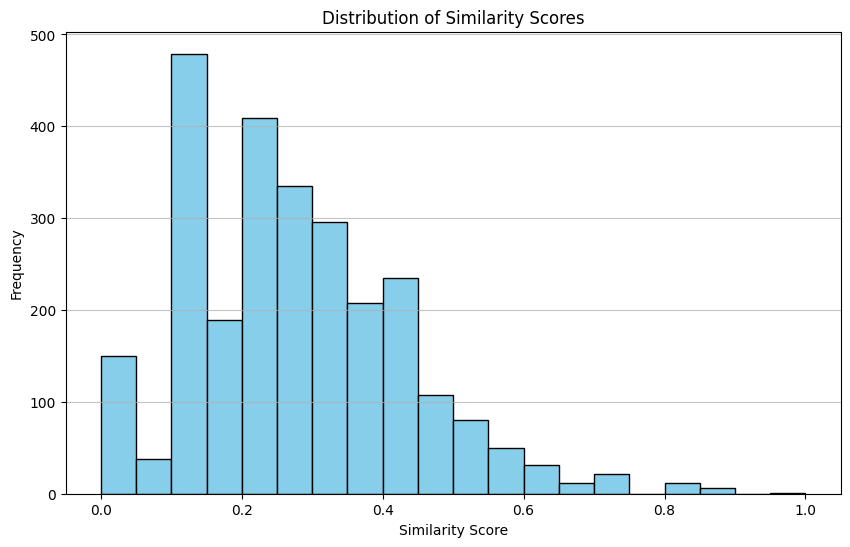

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

recommendations_df = pd.read_csv("recommendations_output.csv")
similarity_scores = recommendations_df[["similarity_score_1", "similarity_score_2", "similarity_score_3"]].values.flatten()

plt.figure(figsize=(10, 6))
plt.hist(similarity_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Summary Statistics

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import mode

recommendations_df = pd.read_csv("recommendations_output.csv")

similarity_scores = recommendations_df[["similarity_score_1", "similarity_score_2", "similarity_score_3"]].values.flatten()

similarity_scores = similarity_scores[~pd.isna(similarity_scores)]

mean_score = np.mean(similarity_scores)
median_score = np.median(similarity_scores)

std_dev = np.std(similarity_scores)

print(f"Mean: {mean_score}")
print(f"Median: {median_score}")
print(f"Standard Deviation: {std_dev}")

Mean: 0.27402551629362276
Median: 0.2519763153394848
Standard Deviation: 0.15587564788380137


# Percentiles

In [5]:
import pandas as pd
import numpy as np

recommendations_df = pd.read_csv("recommendations_output.csv")

similarity_scores = recommendations_df[["similarity_score_1", "similarity_score_2", "similarity_score_3"]].values.flatten()

percentiles = [25, 50, 75]

percentile_values = np.percentile(similarity_scores, percentiles)

for p, value in zip(percentiles, percentile_values):
    print(f"{p}th percentile: {value}")

25th percentile: 0.1490711984999859
50th percentile: 0.2519763153394848
75th percentile: 0.3698001308168194


# Percentage Below Threshold

In [6]:
import pandas as pd
recommendations_df = pd.read_csv("recommendations_output.csv")
similarity_scores = recommendations_df[["similarity_score_1", "similarity_score_2", "similarity_score_3"]].values.flatten()
threshold = 0.3698001308168194
percentage_below_threshold = (similarity_scores <= threshold).mean() * 100
print(f"Percentage of similarity scores below or equal to {threshold}: {percentage_below_threshold:.2f}%")

Percentage of similarity scores below or equal to 0.3698001308168194: 75.08%


# Bar Plot for Threshold Comparison

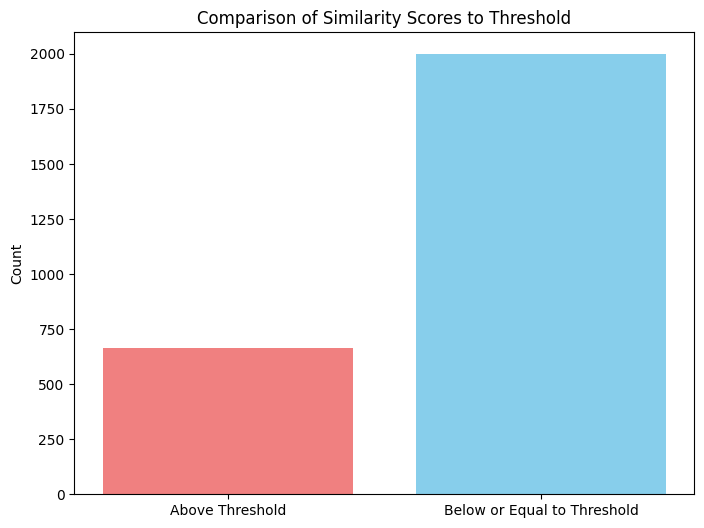

In [7]:
above_threshold = (similarity_scores > threshold).sum()
below_threshold = (similarity_scores <= threshold).sum()

plt.figure(figsize=(8, 6))
plt.bar(['Above Threshold', 'Below or Equal to Threshold'], [above_threshold, below_threshold], color=['lightcoral', 'skyblue'])
plt.title('Comparison of Similarity Scores to Threshold')
plt.ylabel('Count')
plt.show()